In [1]:
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import polars as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
from more_itertools import chunked
from functools import reduce
from typing import List
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import joblib
import os
import torch.nn as nn

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
1
NVIDIA GeForce RTX 3060


In [5]:
df_full = pd.read_parquet('./data/train_val_NN_TORCH.parquet', engine='fastparquet')

In [6]:
# Separar conjuntos
df_train = df_full[df_full['PERIODO'] <= 201908].copy()
df_val = df_full[(df_full['PERIODO'] >= 201909) & (df_full['PERIODO'] <= 201910)].copy()
df_pred = df_full[df_full['PERIODO'] == 201912].copy()
del df_full
gc.collect()

20

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

target_col = 'CLASE_DELTA_LOG1P_Z'

# Columnas categóricas a embeddings
cat_cols = ['ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 
            'ANIO', 'MES', 'TRIMESTRE', 'MES_PROBLEMATICO', 'CUSTOMER_RANK_BIN', 
            'PRODUCT_RANK_BIN']

# Codificación para embeddings
for col in cat_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(str))
    clases_entrenadas = set(le.classes_)
    df_val[col] = df_val[col].map(lambda x: le.transform([x])[0] if x in clases_entrenadas else 0)
    df_pred[col] = df_pred[col].map(lambda x: le.transform([x])[0] if x in clases_entrenadas else 0)
    label_encoders[col] = le

embedding_sizes = [
    (df_train[col].nunique() + 1, min(50, (df_train[col].nunique() + 1) // 2))
    for col in cat_cols
]

# Excluir columnas que no deben ir al modelo
excluir = ['PERIODO', 'CUSTOMER_ID', 'PRODUCT_ID', 'CLASE_DELTA_LOG1P_Z', 'ORDINAL']

feature_cols = [col for col in df_train.columns if col not in excluir and col not in cat_cols]


In [8]:
# No los incluyas en ninguna de estas dos listas
assert 'CUSTOMER_ID' not in feature_cols
assert 'CUSTOMER_ID' not in cat_cols
assert 'PRODUCT_ID' not in feature_cols
assert 'PRODUCT_ID' not in cat_cols
assert 'PERIODO' not in feature_cols
assert 'PERIODO' not in cat_cols
assert 'CLASE_DELTA_LOG1P_Z' not in feature_cols
assert 'CLASE_DELTA_LOG1P_Z' not in cat_cols
assert 'ORDINAL' not in feature_cols
assert 'ORDINAL' not in cat_cols


In [9]:
from torch.utils.data import Dataset
import torch

class TabularDataset(Dataset):
    def __init__(self, df, cat_cols, num_cols, target_col=None):
        self.cat_data = torch.tensor(df[cat_cols].values, dtype=torch.long)
        self.num_data = torch.tensor(df[num_cols].values, dtype=torch.float32)
        self.has_target = target_col is not None
        if self.has_target:
            self.y = torch.tensor(df[target_col].values, dtype=torch.float32).unsqueeze(1)
        else:
            self.y = None

    def __len__(self):
        return len(self.cat_data)

    def __getitem__(self, idx):
        if self.has_target:
            return self.cat_data[idx], self.num_data[idx], self.y[idx]
        else:
            return self.cat_data[idx], self.num_data[idx]


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedMSELossMultiStable(nn.Module):
    def __init__(self, penalty_indices, coefficients, alpha=0.1, debug=False):
        """
        penalty_indices: lista de índices de columnas en x_num (por ejemplo, [10, 11, ..., 20])
        coefficients: lista de coeficientes (ordenados igual que penalty_indices)
        alpha: fuerza de penalización (más bajo por estabilidad en redes grandes)
        debug: si True, imprime el promedio del peso de penalización ocasionalmente
        """
        super().__init__()
        self.penalty_indices = penalty_indices
        self.coefficients = coefficients
        self.alpha = alpha
        self.debug = debug

    def forward(self, preds, targets, x_num):
        # Penalización por muestra (shape: [batch_size, 1])
        penalty = torch.ones_like(targets).float()

        for idx, coef in zip(self.penalty_indices, self.coefficients):
            val = x_num[:, idx:idx+1]  # shape: [batch_size, 1]
            safe_val = torch.tanh(val)  # limitar la magnitud para evitar outliers
            penalty += self.alpha * coef * safe_val.abs()  # siempre positivo

        if self.debug and torch.rand(1).item() < 0.01:
            print(f"[LossDebug] Mean penalty: {penalty.mean().item():.4f}")

        error = (preds - targets) ** 2
        weighted_error = penalty * error

        return weighted_error.mean()


In [11]:
penalty_cols = ['TN_LAG_01_Z', 'TN_LAG_02_Z', 'TN_LAG_03_Z', 'TN_LAG_04_Z','TN_LAG_05_Z','TN_LAG_06_Z','TN_LAG_07_Z',
'TN_LAG_08_Z','TN_LAG_09_Z','TN_LAG_10_Z','TN_LAG_11_Z']
penalty_indices = [feature_cols.index(col) for col in penalty_cols]
print(penalty_cols)
print(penalty_indices)
coefficients = [
    0.236558,
    0.178208,
   -0.060031,
   -0.161875,
   -0.007775,
    0.151936,
    0.043933,
    0.142839,
    0.103804,
    0.119211,
    0.073671
]
# loss_fn = WeightedMSELossMulti(penalty_indices, coefficients, alpha=0.5)

loss_fn = WeightedMSELossMultiStable(
    penalty_indices=penalty_indices,
    coefficients=coefficients,
    alpha=0.1,      # más suave
    debug=True      # activalo si querés monitorear internamente
)

#loss_fn = WeightedMSELossMulti(penalty_indices=penalty_cols, alpha=0.5)

['TN_LAG_01_Z', 'TN_LAG_02_Z', 'TN_LAG_03_Z', 'TN_LAG_04_Z', 'TN_LAG_05_Z', 'TN_LAG_06_Z', 'TN_LAG_07_Z', 'TN_LAG_08_Z', 'TN_LAG_09_Z', 'TN_LAG_10_Z', 'TN_LAG_11_Z']
[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


In [12]:
assert all(col in df_train.columns for col in cat_cols), "Faltan columnas categóricas"
assert all(col in df_train.columns for col in feature_cols), "Faltan columnas numéricas"
assert target_col in df_train.columns, "Falta la variable objetivo"


In [13]:
batch_size = 4096

train_dataset = TabularDataset(df_train, cat_cols, feature_cols, target_col)
val_dataset = TabularDataset(df_val, cat_cols, feature_cols, target_col)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
print(cat_cols)
print(feature_cols)
print(target_col)

['ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'ANIO', 'MES', 'TRIMESTRE', 'MES_PROBLEMATICO', 'CUSTOMER_RANK_BIN', 'PRODUCT_RANK_BIN']
['MES_SIN', 'MES_COS', 'CUSTOMER_ID_Z', 'PRODUCT_ID_Z', 'CUST_REQUEST_QTY_Z', 'CUST_REQUEST_TN_Z', 'TN_Z', 'MEDIA_MOVIL_3M_CLI_PROD_Z', 'MEDIA_MOVIL_6M_CLI_PROD_Z', 'MEDIA_MOVIL_12M_CLI_PROD_Z', 'DESVIO_MOVIL_3M_CLI_PROD_Z', 'DESVIO_MOVIL_6M_CLI_PROD_Z', 'DESVIO_MOVIL_12M_CLI_PROD_Z', 'MEDIA_MOVIL_3M_PROD_Z', 'MEDIA_MOVIL_6M_PROD_Z', 'MEDIA_MOVIL_12M_PROD_Z', 'DESVIO_MOVIL_3M_PROD_Z', 'DESVIO_MOVIL_6M_PROD_Z', 'DESVIO_MOVIL_12M_PROD_Z', 'MEDIA_MOVIL_3M_CLI_Z', 'MEDIA_MOVIL_6M_CLI_Z', 'MEDIA_MOVIL_12M_CLI_Z', 'DESVIO_MOVIL_3M_CLI_Z', 'DESVIO_MOVIL_6M_CLI_Z', 'DESVIO_MOVIL_12M_CLI_Z', 'TN_LAG_01_Z', 'TN_LAG_02_Z', 'TN_LAG_03_Z', 'TN_LAG_04_Z', 'TN_LAG_05_Z', 'TN_LAG_06_Z', 'TN_LAG_07_Z', 'TN_LAG_08_Z', 'TN_LAG_09_Z', 'TN_LAG_10_Z', 'TN_LAG_11_Z', 'TN_LAG_12_Z', 'TN_LAG_13_Z', 'TN_LAG_14_Z', 'TN_LAG_15_Z', 'ORDINAL_Z', 'TN_DELTA_01_Z', 'TN_DELT

In [14]:
import torch.nn.functional as F

class TabularNNImproved(nn.Module):
    def __init__(self, embedding_sizes, num_numerical, hidden_sizes=[512, 512, 256, 128], dropout=0.1):
        super().__init__()
        
        # Embedding layers
        self.embeddings = nn.ModuleList([
            nn.Embedding(ni, nf) for ni, nf in embedding_sizes
        ])
        embedding_dim = sum([nf for _, nf in embedding_sizes])
        self.embedding_dropout = nn.Dropout(dropout)

        # Total input size after embedding + numerical
        input_size = embedding_dim + num_numerical

        # Hidden layers
        layers = []
        for h in hidden_sizes:
            layers.append(nn.Linear(input_size, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            input_size = h

        # Output layer
        layers.append(nn.Linear(input_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x_cat, x_num):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, dim=1)
        x = self.embedding_dropout(x)
        x = torch.cat([x, x_num], dim=1)
        return self.model(x)


In [15]:
import torch

# Detectar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Crear el modelo
model = TabularNNImproved(
    embedding_sizes=embedding_sizes,
    num_numerical=len(feature_cols),
    hidden_sizes=[4096,2048,1024,512, 512, 256, 128],
    dropout=0.3
).to(device)
model.to(device)
print(model)


TabularNNImproved(
  (embeddings): ModuleList(
    (0): Embedding(5, 2)
    (1): Embedding(16, 8)
    (2): Embedding(84, 42)
    (3): Embedding(36, 18)
    (4): Embedding(67, 33)
    (5): Embedding(4, 2)
    (6): Embedding(13, 6)
    (7): Embedding(5, 2)
    (8): Embedding(3, 1)
    (9-10): 2 x Embedding(11, 5)
  )
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (model): Sequential(
    (0): Linear(in_features=209, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=4096, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [16]:
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import numpy as np

def train_model(
    model, train_loader, val_loader=None, n_epochs=20, lr=1e-3, alpha=0.5, patience=3,
    penalty_indices=None, coefficients=None
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = WeightedMSELossMultiStable(
        penalty_indices=penalty_indices, coefficients=coefficients, alpha=alpha
    )
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(n_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        for cats, conts, y in train_loader:
            cats, conts, y = cats.to(device), conts.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(cats, conts)
            loss = criterion(y_pred, y, conts)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * y.size(0)

        train_loss /= len(train_loader.dataset)

        # Validación (solo si hay val_loader)
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            y_true_list = []
            y_pred_list = []
            with torch.no_grad():
                for cats, conts, y in val_loader:
                    cats, conts, y = cats.to(device), conts.to(device), y.to(device)
                    y_pred = model(cats, conts)
                    loss = criterion(y_pred, y, conts)
                    val_loss += loss.item() * y.size(0)
                    y_true_list.append(y.cpu().numpy())
                    y_pred_list.append(y_pred.cpu().numpy())

            val_loss /= len(val_loader.dataset)
            y_true = np.concatenate(y_true_list)
            y_pred = np.concatenate(y_pred_list)

            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            print(
                f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}"
            )

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if patience is not None and epochs_without_improvement >= patience:
                    print("🔴 Early stopping triggered")
                    break
        else:
            # Si no hay val_loader, solo mostrar train_loss
            print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f}")

    # Restaurar el mejor modelo solo si hubo validación
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Retornar resultados solo si hubo validación, si no, devolver None
    if val_loader is not None:
        return y_true, y_pred
    else:
        return None, None



# Búsqueda de hiperparámetros (Grid Search)
Probamos distintas combinaciones de hiperparámetros y seleccionamos la que da mejor MAE en validación.


In [47]:
from itertools import product
import torch
import gc
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Definir el espacio de búsqueda
param_grid = {
    'lr': [1e-3, 5e-4],
    'dropout': [0.2, 0.3],
    'hidden_sizes': [
        [1024, 512, 256],
        [2048, 1024, 512, 256]
    ],
    'alpha': [0,0.1,0.3, 0.5, 0.7,0.9]
}

# Generar todas las combinaciones posibles
param_combinations = list(product(
    param_grid['lr'],
    param_grid['dropout'],
    param_grid['hidden_sizes'],
    param_grid['alpha']
))

results = []
best_mae = float('inf')

# Loop de entrenamiento por combinación
for lr, dropout, hidden_sizes, alpha in param_combinations:
    print(f"\n🔧 Entrenando con: lr={lr}, dropout={dropout}, hidden_sizes={hidden_sizes}, alpha={alpha}")

    # Crear modelo y mover a dispositivo
    model = TabularNNImproved(
        embedding_sizes=embedding_sizes,
        num_numerical=len(feature_cols),
        hidden_sizes=hidden_sizes,
        dropout=dropout
    ).to(device)

    # Entrenamiento corto para tuning
    y_true_gs, y_pred_gs = train_model(
        model, train_loader, val_loader,
        n_epochs=8, lr=lr, alpha=alpha, patience=2,penalty_indices=penalty_indices,coefficients=coefficients
    )

    mae = mean_absolute_error(y_true_gs, y_pred_gs)

    # Guardar resultados
    results.append({
        'lr': lr,
        'dropout': dropout,
        'hidden_sizes': hidden_sizes,
        'alpha': alpha,
        'mae': mae
    })

    print(f"✅ MAE = {mae:.4f}")

    # Guardar modelo si es el mejor
    if mae < best_mae:
        best_mae = mae
        torch.save(model.state_dict(), f"best_model_mae{mae:.4f}_lr{lr}_do{dropout}_a{alpha}.pth")
        print("💾 Modelo guardado (mejor hasta ahora)")

    # Limpiar memoria GPU
    del model
    torch.cuda.empty_cache()
    gc.collect()

# Convertir a DataFrame y mostrar top 5
results_df = pd.DataFrame(results).sort_values(by='mae')
print("\n📊 Mejores combinaciones:")
print(results_df.head())

# Guardar resultados a disco
results_df.to_csv("gridsearch_results.csv", index=False)



🔧 Entrenando con: lr=0.001, dropout=0.2, hidden_sizes=[1024, 512, 256], alpha=0
Epoch 1/8 | Train Loss: 0.7968 | Val Loss: 0.6248 | MAE: 0.2065 | R²: 0.3953
Epoch 2/8 | Train Loss: 0.7511 | Val Loss: 0.6281 | MAE: 0.1831 | R²: 0.3936
Epoch 3/8 | Train Loss: 0.7396 | Val Loss: 0.6224 | MAE: 0.1760 | R²: 0.3980
Epoch 4/8 | Train Loss: 0.7312 | Val Loss: 0.6126 | MAE: 0.1908 | R²: 0.4089
Epoch 5/8 | Train Loss: 0.7254 | Val Loss: 0.6153 | MAE: 0.1883 | R²: 0.4058
Epoch 6/8 | Train Loss: 0.7186 | Val Loss: 0.6340 | MAE: 0.1884 | R²: 0.3901
🔴 Early stopping triggered
✅ MAE = 0.1884
💾 Modelo guardado (mejor hasta ahora)

🔧 Entrenando con: lr=0.001, dropout=0.2, hidden_sizes=[1024, 512, 256], alpha=0.1
Epoch 1/8 | Train Loss: 0.7843 | Val Loss: 0.6339 | MAE: 0.1860 | R²: 0.3894
Epoch 2/8 | Train Loss: 0.7495 | Val Loss: 0.6370 | MAE: 0.1983 | R²: 0.3853
Epoch 3/8 | Train Loss: 0.7405 | Val Loss: 0.6216 | MAE: 0.1925 | R²: 0.4005
Epoch 4/8 | Train Loss: 0.7318 | Val Loss: 0.6312 | MAE: 0.1948

In [17]:
from torch.utils.data import ConcatDataset


# 📦 Dataset completo ya procesado
# Usamos el mismo dataset de entrenamiento ya creado
# Concatenar train_dataset y val_dataset
train_val_dataset = ConcatDataset([train_dataset, val_dataset])


In [18]:
from torch.utils.data import DataLoader
# Definí tu DataLoader final
train_loader_full = DataLoader(train_val_dataset, batch_size=1024, shuffle=True)


In [19]:
import torch

configs = [
    {"lr": 0.001, "dropout": 0.3, "hidden_sizes": [1024, 512, 256], "alpha": 0.3, "n_epochs": 6, "name": "modelo_1"},
    {"lr": 0.001, "dropout": 0.2, "hidden_sizes": [2048, 1024, 512, 256], "alpha": 0.7, "n_epochs": 3, "name": "modelo_2"},
    {"lr": 0.0005, "dropout": 0.2, "hidden_sizes": [2048, 1024, 512, 256], "alpha": 0.3, "n_epochs": 6, "name": "modelo_3"},
    {"lr": 0.0005, "dropout": 0.2, "hidden_sizes": [1024, 512, 256], "alpha": 0.0, "n_epochs": 5, "name": "modelo_4"},
    {"lr": 0.0005, "dropout": 0.3, "hidden_sizes": [2048, 1024, 512, 256], "alpha": 0.1, "n_epochs": 6, "name": "modelo_5"},
]

for cfg in configs:
    print(f"\n🔧 Entrenando {cfg['name']} - lr={cfg['lr']} dropout={cfg['dropout']} hidden={cfg['hidden_sizes']} alpha={cfg['alpha']} epochs={cfg['n_epochs']}")
    model = TabularNNImproved(
        embedding_sizes=embedding_sizes,
        num_numerical=len(feature_cols),
        hidden_sizes=cfg['hidden_sizes'],
        dropout=cfg['dropout']
    ).to(device)
    
    y_true, y_pred = train_model(
        model,
        train_loader_full,
        val_loader=None,
        n_epochs=cfg['n_epochs'],
        lr=cfg['lr'],
        alpha=cfg['alpha'],
        patience=None, # No early stopping en entrenamiento final
        penalty_indices=penalty_indices,
        coefficients=coefficients
    )
    torch.save(model.state_dict(), f"{cfg['name']}_final.pt")
    print(f"💾 Modelo guardado: {cfg['name']}_final.pt")


🔧 Entrenando modelo_1 - lr=0.001 dropout=0.3 hidden=[1024, 512, 256] alpha=0.3 epochs=6
Epoch 1/6 | Train Loss: 0.7272
Epoch 2/6 | Train Loss: 0.6975
Epoch 3/6 | Train Loss: 0.6865
Epoch 4/6 | Train Loss: 0.6787
Epoch 5/6 | Train Loss: 0.6730
Epoch 6/6 | Train Loss: 0.6698
💾 Modelo guardado: modelo_1_final.pt

🔧 Entrenando modelo_2 - lr=0.001 dropout=0.2 hidden=[2048, 1024, 512, 256] alpha=0.7 epochs=3
Epoch 1/3 | Train Loss: 0.8243
Epoch 2/3 | Train Loss: 0.7874
Epoch 3/3 | Train Loss: 0.7749
💾 Modelo guardado: modelo_2_final.pt

🔧 Entrenando modelo_3 - lr=0.0005 dropout=0.2 hidden=[2048, 1024, 512, 256] alpha=0.3 epochs=6
Epoch 1/6 | Train Loss: 0.7209
Epoch 2/6 | Train Loss: 0.6897
Epoch 3/6 | Train Loss: 0.6784
Epoch 4/6 | Train Loss: 0.6711
Epoch 5/6 | Train Loss: 0.6641
Epoch 6/6 | Train Loss: 0.6592
💾 Modelo guardado: modelo_3_final.pt

🔧 Entrenando modelo_4 - lr=0.0005 dropout=0.2 hidden=[1024, 512, 256] alpha=0.0 epochs=5
Epoch 1/5 | Train Loss: 0.6462
Epoch 2/5 | Train Loss:

In [20]:
import torch

# Definí los hiperparámetros para modelo_6
modelo_6_cfg = {
    "lr": 0.001,
    "dropout": 0.2,
    "hidden_sizes": [2048, 1024, 512, 256],
    "alpha": 0.7,
    "n_epochs": 6,  # Cambia este valor si querés más o menos epochs
    "name": "modelo_6"
}

print(f"\n🔧 Entrenando {modelo_6_cfg['name']} - lr={modelo_6_cfg['lr']} dropout={modelo_6_cfg['dropout']} hidden={modelo_6_cfg['hidden_sizes']} alpha={modelo_6_cfg['alpha']} epochs={modelo_6_cfg['n_epochs']}")

model = TabularNNImproved(
    embedding_sizes=embedding_sizes,
    num_numerical=len(feature_cols),
    hidden_sizes=modelo_6_cfg['hidden_sizes'],
    dropout=modelo_6_cfg['dropout']
).to(device)

y_true, y_pred = train_model(
    model,
    train_loader_full,
    val_loader=None,
    n_epochs=modelo_6_cfg['n_epochs'],
    lr=modelo_6_cfg['lr'],
    alpha=modelo_6_cfg['alpha'],
    patience=None, # No early stopping en entrenamiento final
    penalty_indices=penalty_indices,
    coefficients=coefficients
)

torch.save(model.state_dict(), f"{modelo_6_cfg['name']}_final.pt")
print(f"💾 Modelo guardado: {modelo_6_cfg['name']}_final.pt")



🔧 Entrenando modelo_6 - lr=0.001 dropout=0.2 hidden=[2048, 1024, 512, 256] alpha=0.7 epochs=6
Epoch 1/6 | Train Loss: 0.8228
Epoch 2/6 | Train Loss: 0.7869
Epoch 3/6 | Train Loss: 0.7746
Epoch 4/6 | Train Loss: 0.7646
Epoch 5/6 | Train Loss: 0.7579
Epoch 6/6 | Train Loss: 0.7507
💾 Modelo guardado: modelo_6_final.pt


1. Preparar df_pred (ya codifiqué, solo asegurar los dtypes)

In [21]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Asegurarse que las columnas categóricas estén como int64 (para embeddings)
for col in cat_cols:
    df_pred[col] = df_pred[col].astype(np.int64)

# Asegurarse que las columnas numéricas estén como float32
for col in feature_cols:
    df_pred[col] = df_pred[col].astype(np.float32)


2. Crear DataLoader para predicción

In [22]:
X_cats = torch.LongTensor(df_pred[cat_cols].values)
X_conts = torch.FloatTensor(df_pred[feature_cols].values)
ds_pred = TensorDataset(X_cats, X_conts)
pred_loader = DataLoader(ds_pred, batch_size=8192, shuffle=False)

3. Función de predicción

In [23]:
def predict_model(model, loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for X_cats, X_conts in loader:
            X_cats = X_cats.to(device)
            X_conts = X_conts.to(device)
            output = model(X_cats, X_conts)
            preds.append(output.cpu().numpy().squeeze())
    return np.concatenate(preds)


4. Hacer predicción con cada modelo y armar el ensemble

In [33]:
all_preds = []

for cfg in configs:
    # Instanciá el modelo igual que en entrenamiento
    model = TabularNNImproved(
        embedding_sizes=embedding_sizes,
        num_numerical=len(feature_cols),
        hidden_sizes=cfg['hidden_sizes'],
        dropout=cfg['dropout']
    ).to(device)
    
    # Cargar pesos
    model.load_state_dict(torch.load(f"{cfg['name']}_final.pt", map_location=device))
    
    # Predecir
    preds = predict_model(model, pred_loader, device)
    all_preds.append(preds)

all_preds = np.stack(all_preds)  # shape (n_models, N)

# Ensemble por media
ensemble_pred_mean = all_preds.mean(axis=0)
df_pred["y_pred_ensemble_mean"] = ensemble_pred_mean

# Ensemble por mediana
ensemble_pred_median = np.median(all_preds, axis=0)
df_pred["y_pred_ensemble_median"] = ensemble_pred_median

# Opcional: guardar cada predicción individual
for i, cfg in enumerate(configs):
    df_pred[f"y_pred_{cfg['name']}"] = all_preds[i]



In [37]:
# Imprimir todas las filas sin truncar
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)      
print("Predicciones guardadas en df_pred")
print(df_pred[['CUSTOMER_ID', 'PRODUCT_ID', 'y_pred_ensemble_mean', 'y_pred_ensemble_median']].head(100))

Predicciones guardadas en df_pred
       CUSTOMER_ID  PRODUCT_ID  y_pred_ensemble_mean  y_pred_ensemble_median
14789        10065       20001              2.696167                2.550928
14790        10066       20001             -6.094566               -5.971779
14791        10064       20001             -0.012800               -0.061770
14792        10063       20001             -1.411647               -1.525971
14793        10062       20001             -1.754637               -1.641423
14794        10061       20001             -0.469546               -0.530309
14795        10060       20001             -1.535050               -1.598010
14796        10059       20001              1.699076                1.705424
14797        10058       20001              0.272591                0.279216
14798        10057       20001              6.007133                6.234688
14799        10056       20001              1.098930                1.171462
14800        10055       20001            

/tmp/ipykernel_5116/2935037528.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred["diff_mean_median"] = df_pred["y_pred_ensemble_mean"] - df_pred["y_pred_ensemble_median"]


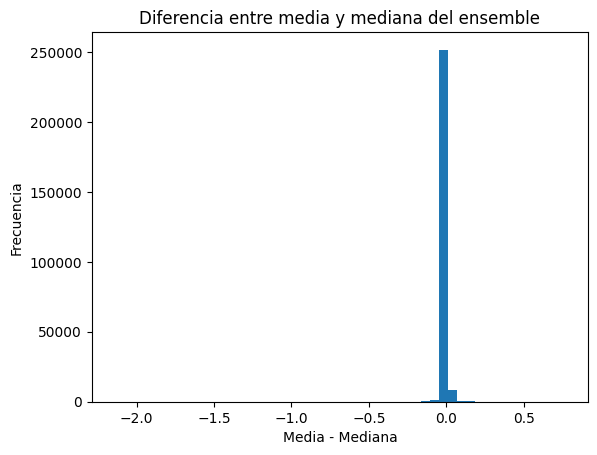

In [38]:
import matplotlib.pyplot as plt

df_pred["diff_mean_median"] = df_pred["y_pred_ensemble_mean"] - df_pred["y_pred_ensemble_median"]
plt.hist(df_pred["diff_mean_median"], bins=50)
plt.title("Diferencia entre media y mediana del ensemble")
plt.xlabel("Media - Mediana")
plt.ylabel("Frecuencia")
plt.show()


In [40]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)      
outliers = df_pred[ df_pred["diff_mean_median"].abs() > 1 ]  # Ajustá el umbral a tu escala
print(outliers[["CUSTOMER_ID", "PRODUCT_ID", "y_pred_ensemble_mean", "y_pred_ensemble_median", "diff_mean_median"]])


       CUSTOMER_ID  PRODUCT_ID  y_pred_ensemble_mean  y_pred_ensemble_median  \
15018        10013       20001            -42.944492              -40.944237   
15027        10004       20001             39.921616               42.064365   
30275        10002       20002              9.708448               10.920622   

       diff_mean_median  
15018         -2.000256  
15027         -2.142750  
30275         -1.212173  


In [43]:
idx = 30275  # O el índice del caso raro
print(df_pred.loc[idx, [f"y_pred_{cfg['name']}" for cfg in configs]])


y_pred_modelo_1    11.116959
y_pred_modelo_2     9.070816
y_pred_modelo_3     5.840777
y_pred_modelo_4    10.920622
y_pred_modelo_5    11.593066
Name: 30275, dtype: float64


1. Invertir el Z-score

In [44]:
# Por ejemplo, para la media:
df_pred['CLASE_DELTA_LOG1P_pred_mean'] = (
    df_pred['y_pred_ensemble_mean'] * 0.2535427832171512 + (-0.0002512964473318228)
)
# Y para la mediana:
df_pred['CLASE_DELTA_LOG1P_pred_median'] = (
    df_pred['y_pred_ensemble_median'] * 0.2535427832171512 + (-0.0002512964473318228)
)


/tmp/ipykernel_5116/1054342071.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred['CLASE_DELTA_LOG1P_pred_mean'] = (
/tmp/ipykernel_5116/1054342071.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred['CLASE_DELTA_LOG1P_pred_median'] = (


2. Invertir la log-transformación signada

In [45]:
def inverse_log_transform_signed(x):
    return np.sign(x) * np.expm1(np.abs(x))

# Para la media:
df_pred['CLASE_DELTA_pred_mean'] = inverse_log_transform_signed(df_pred['CLASE_DELTA_LOG1P_pred_mean'])
# Para la mediana:
df_pred['CLASE_DELTA_pred_median'] = inverse_log_transform_signed(df_pred['CLASE_DELTA_LOG1P_pred_median'])

/tmp/ipykernel_5116/1400988177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred['CLASE_DELTA_pred_mean'] = inverse_log_transform_signed(df_pred['CLASE_DELTA_LOG1P_pred_mean'])
/tmp/ipykernel_5116/1400988177.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred['CLASE_DELTA_pred_median'] = inverse_log_transform_signed(df_pred['CLASE_DELTA_LOG1P_pred_median'])


/tmp/ipykernel_5116/2210162046.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred["diff_pred_mean_median"] = df_pred["CLASE_DELTA_pred_mean"] - df_pred["CLASE_DELTA_pred_median"]


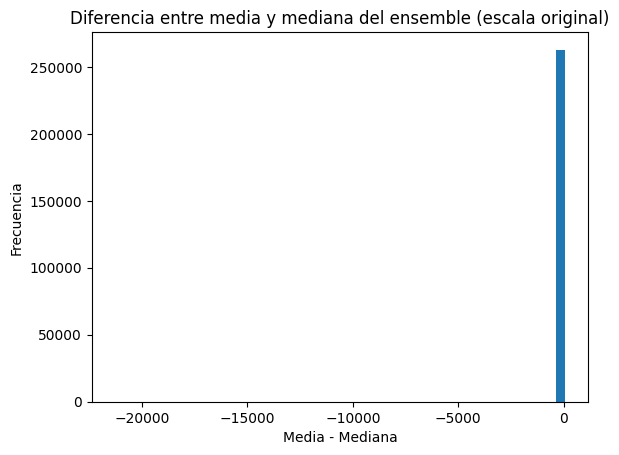

In [46]:
import matplotlib.pyplot as plt

df_pred["diff_pred_mean_median"] = df_pred["CLASE_DELTA_pred_mean"] - df_pred["CLASE_DELTA_pred_median"]

plt.hist(df_pred["diff_pred_mean_median"], bins=50)
plt.title("Diferencia entre media y mediana del ensemble (escala original)")
plt.xlabel("Media - Mediana")
plt.ylabel("Frecuencia")
plt.show()


In [47]:
umbral = 1000  # O el valor que consideres relevante para tu negocio
outliers = df_pred[df_pred["diff_pred_mean_median"].abs() > umbral]
print(outliers[["CUSTOMER_ID", "PRODUCT_ID", "CLASE_DELTA_pred_mean", "CLASE_DELTA_pred_median", "diff_pred_mean_median"]])


       CUSTOMER_ID  PRODUCT_ID  CLASE_DELTA_pred_mean  \
15018        10013       20001          -53556.835938   
15027        10004       20001           24873.185547   

       CLASE_DELTA_pred_median  diff_pred_mean_median  
15018            -32252.042969          -21304.792969  
15027             42823.453125          -17950.267578  


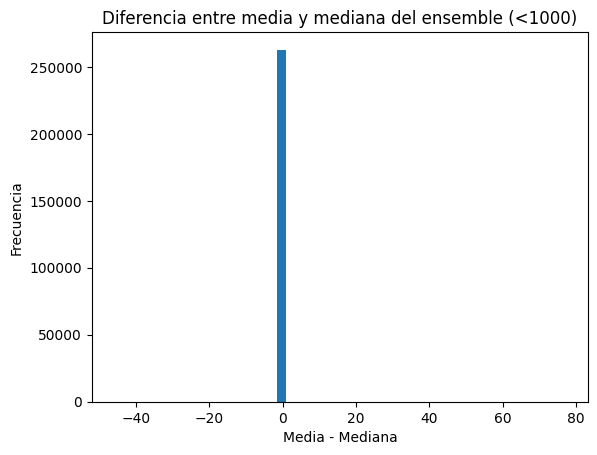

In [48]:
plt.hist(df_pred[df_pred["diff_pred_mean_median"].abs() < 1000]["diff_pred_mean_median"], bins=50)
plt.title("Diferencia entre media y mediana del ensemble (<1000)")
plt.xlabel("Media - Mediana")
plt.ylabel("Frecuencia")
plt.show()


In [49]:
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')

In [53]:
# Calcular las medias y medianas por CUSTOMER_ID y PRODUCT_ID de CLASE_DELTA
df_means = df_full.groupby(['CUSTOMER_ID', 'PRODUCT_ID'])['CLASE_DELTA'].mean().reset_index()
df_means.rename(columns={'CLASE_DELTA': 'CLASE_DELTA_mean'}, inplace=True)
df_medians = df_full.groupby(['CUSTOMER_ID', 'PRODUCT_ID'])['CLASE_DELTA'].median().reset_index()
df_medians.rename(columns={'CLASE_DELTA': 'CLASE_DELTA_median'}, inplace=True)
# Unir las medias y medianas al DataFrame de predicciones solo las que existen en ambos conjuntos
df_pred = df_pred.merge(df_means, on=['CUSTOMER_ID', 'PRODUCT_ID'], how='inner') 
df_pred = df_pred.merge(df_medians, on=['CUSTOMER_ID', 'PRODUCT_ID'], how='inner')


In [ ]:
plt.hist(df_pred[df_pred["diff_pred_mean_median"].abs() < 1000]["diff_pred_mean_median"], bins=50)
plt.title("Diferencia entre media y mediana del ensemble (<1000)")
plt.xlabel("Media - Mediana")
plt.ylabel("Frecuencia")
plt.show()

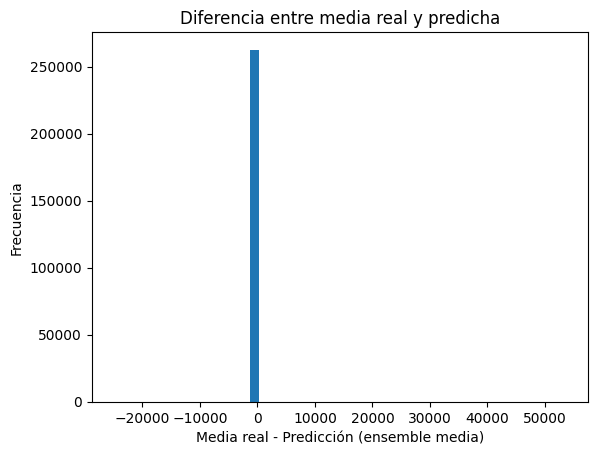

In [58]:
plt.hist(df_pred["diff_real_vs_pred_mean"], bins=50)
plt.title("Diferencia entre media real y predicha")
plt.xlabel("Media real - Predicción (ensemble media)")
plt.ylabel("Frecuencia")
plt.show()


In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(df_pred["CLASE_DELTA_mean"], df_pred["CLASE_DELTA_pred_mean"])
rmse = mean_squared_error(df_pred["CLASE_DELTA_mean"], df_pred["CLASE_DELTA_pred_mean"], squared=False)
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")


ValueError: Input contains NaN.